# Max Regression

A demo of the toy max-regression problem from the paper. These models learn to approximate the largest number in the given set, regardless of the order presented.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import settransformer as stf

---
## Data Generation

The following function generates a batch sets, each consisting of *length* numbers.

In [2]:
def gen_data(batch_size, length=5):
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    return x, y # (batch_size, length)

In [3]:
x, y = gen_data(3, 5)

In [4]:
print(x.shape, y.shape)

(3, 5) (3,)


In [5]:
x

array([[94, 16, 34, 53, 97],
       [53, 47, 88, 96, 58],
       [56, 94, 51,  7, 43]])

In [6]:
y

array([97, 96, 94])

---
## Model

This model learns to approximate the largest number in the given set of numbers, regardless of the order presented.

In [7]:
def create_model(
    embed_dim=64,
    num_heads=4,
    stack=2,
    use_layernorm=False,
    pre_layernorm=False,
    use_keras_mha=False # Use Keras' MHA implementation over the traditional Vaswani implementation
):
    y = x = keras.layers.Input((None,))
    y = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(y)
    y = keras.layers.Dense(embed_dim)(y)
    for _ in range(stack):
        y = stf.SetAttentionBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                use_layernorm=use_layernorm,
                pre_layernorm=pre_layernorm,
                use_keras_mha=use_keras_mha)(y)

    y = stf.PoolingByMultiHeadAttention(
            num_seeds=1,
            embed_dim=embed_dim,
            num_heads=1,
            use_layernorm=use_layernorm,
            pre_layernorm=pre_layernorm,
            use_keras_mha=use_keras_mha,
            is_final_block=True)(y)
    y = keras.layers.Dense(1)(y)
    y = keras.layers.Lambda(lambda x: tf.squeeze(x))(y)
    
    return keras.Model(x, y)

---
## Training

In [8]:
model = create_model()
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

2022-06-09 03:58:36.428738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 03:58:36.428944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 03:58:36.433901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 03:58:36.434114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 03:58:36.434291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [9]:
x[:2]

array([[94, 16, 34, 53, 97],
       [53, 47, 88, 96, 58]])

In [10]:
model.predict(x[:2])

2022-06-09 03:58:40.827510: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


array([24.450964, 10.880541], dtype=float32)

In [11]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [12]:
history = model.fit(x, y, epochs=500, verbose=0)

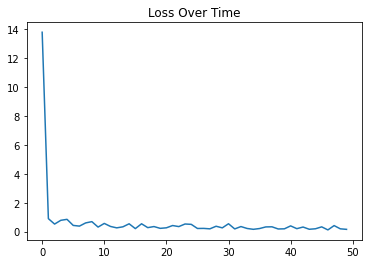

In [13]:
plt.plot(history.history["loss"][::10])
plt.title("Loss Over Time")
plt.show()

In [14]:
x[:3]

array([[ 7, 56, 28, 42, 56],
       [24, 20, 26, 95, 89],
       [23, 53, 20, 73, 22]])

In [15]:
model.predict(x[:3])

array([56.22653 , 94.983665, 73.09105 ], dtype=float32)